In [111]:
from qiskit import *
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler import generate_preset_pass_manager

def oracle(s):
    n = len(s)
    qc = QuantumCircuit(n+1)

    for i, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(i, n) 
    return qc

def bernstein_varizani(oracle, n):
    
    
    #Step 1
    qc = QuantumCircuit(n + 1, n)
    
    #Step 2
    qc.h(np.arange(0, n, 1))
    
    
  
    #Step 3
#Preparation step: We need the ancilla qubit to be prepared to |1>. 
#                  There in no built-in way in Qiskit to achieve this, since all qubits are initialized in state |0>.
#                  For this reason, we are applying a Pauli X gate to the ancilla qubit, so we flip it's state from |0> to |1>
    qc.x(n)
    qc.h(n)
    
    
    #Step 4
    qc.barrier()
    qc.compose(oracle, qubits=range(n + 1), inplace=True)
    qc.barrier()
    
    
    #Step 5
    qc.h(np.arange(0, n, 1))
    qc.barrier()
    
    
    #Step 6
    qc.measure(np.arange(0, n, 1),np.arange(0, n, 1))
    
    return qc

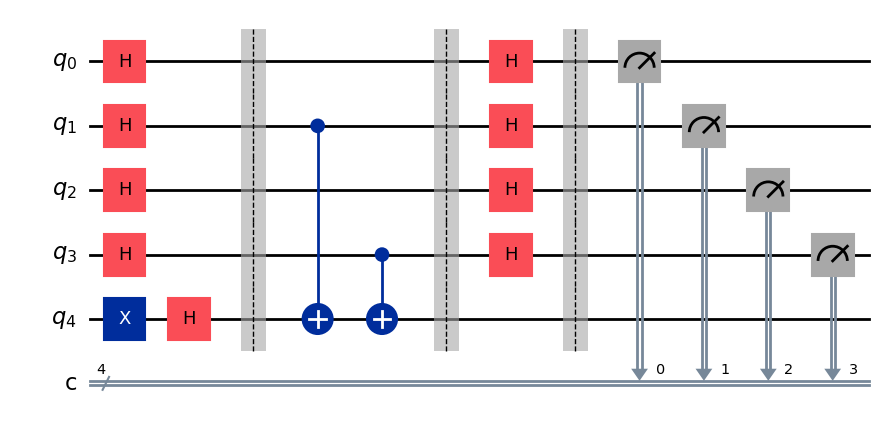

In [112]:
#Example required by the assignment
s = "1010"
o = oracle(s)
qc = bernstein_varizani(o, len(s))
qc.draw('mpl')

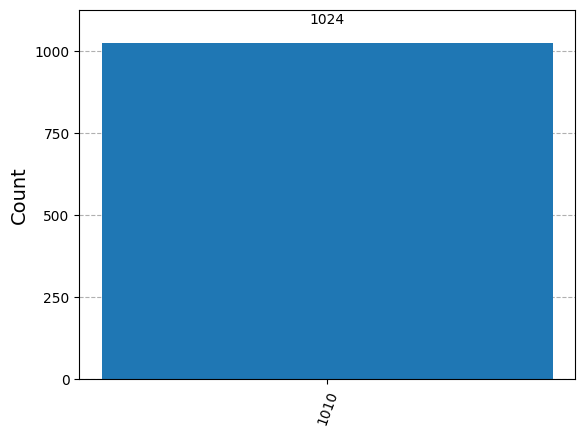

In [113]:
#Simulation using StatevectorSampler
backend = FakeBrisbane()
pm = generate_preset_pass_manager(optimization_level=1)
transpiled_qc = pm.run(qc)
statevectorSampler = StatevectorSampler()
job = statevectorSampler.run([transpiled_qc])
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)

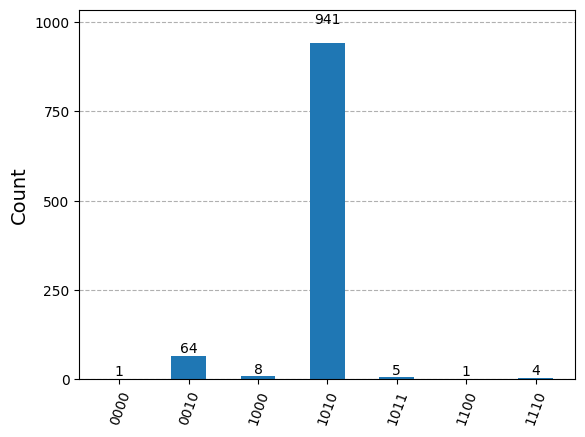

In [114]:
#Simulation using SamplerV2
backend = FakeBrisbane()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_qc = pm.run(qc)
sampler = SamplerV2(backend)
job = sampler.run([transpiled_qc])
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)

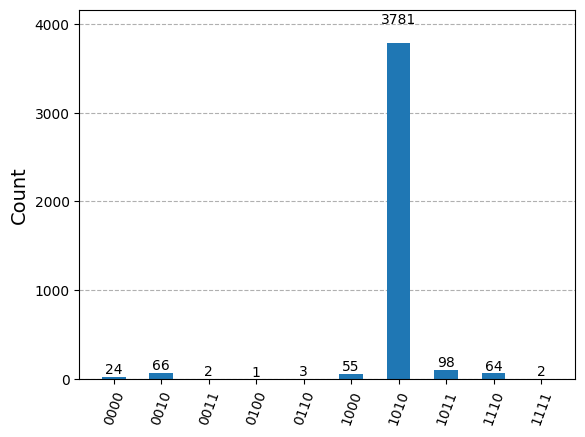

In [110]:
#Execution on a real quantum computer
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token='QISKIT_TOKEN>'
)

backend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

transpiled_qc = pm.run(qc) 

sampler = SamplerV2(backend)
shots=1024
job = sampler.run([transpiled_qc])
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)